<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/ProbabilisticClassificationClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification and clustering: probabilistic modeling approach

Here, we will extend out discussion on estimation theory to classification and clusterin problems.

In [1]:
import numpy as np
import pylab as pl

# Setting it so figs will be a bit bigger
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.33]
plt.rcParams['figure.dpi']  = 120

## We will rely heavily on the ```scikit-learn``` library

The ```sklearn``` library is a mature, well-tested library of implementations of many standard machine-learning models and provides a clean API to work with. In addition to being able to fit models and draw predictions for new inputs, ```sklearn``` also provides many useful utilities for handling data. It also has functions for creating toy datasets which can be used to understand the pros and cons of various models.  The library is designed to work in conjunction with ```numpy```, ```scipy```, ```matplotlib```, and ```pandas```.

### Start by making a 2D dataset with 2 classes.

In [2]:
from sklearn import datasets
n_classes = 2
n_features = 2
n_samples = 200
n_redundant = 0
n_clusters_per_class = 1
class_sep = 0.8
X, y = datasets.make_classification(n_classes=n_classes, n_features=n_features,
                                    n_samples=n_samples, n_redundant=n_redundant,
                                    n_clusters_per_class=n_clusters_per_class,
                                    class_sep=class_sep, random_state=0)

### Visualize the dataset

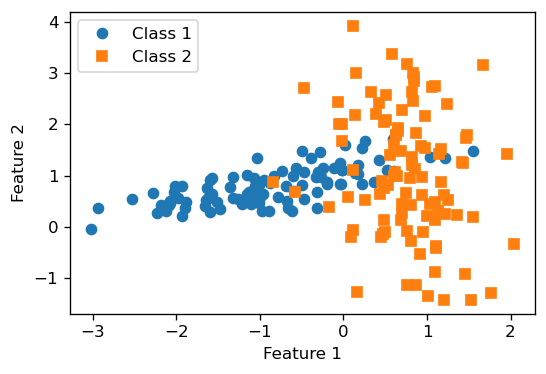

In [3]:
import itertools
marker = itertools.cycle(('o', 's', '*', 'v', '^', 'x')) 
for c in range(n_classes):
    pl.plot(X[y==c, 0], X[y==c, 1], linestyle='', marker=next(marker))
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')
pl.legend(('Class 1', 'Class 2'), loc='best')

## Construct a naive-Bayes classifier and test it by splitting the dataset

For simplicity, we will use the Gaussian naive-Bayes model where the value of each feature is modeled as coming from a 1D normal distribution that is conditioned on class but independent of other features.

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

model = GaussianNB()
model.fit(X_train, y_train)
y_predicted_train = model.predict(X_train)
y_predicted_test = model.predict(X_test)

acc_train = (y_predicted_train == y_train).sum() * 100. / y_train.shape[0]
acc_test = (y_predicted_test == y_test).sum() * 100. / y_test.shape[0]

print(f'Training accuracy = {acc_train:0.1f}%, Test accuracy = {acc_test:0.1f}%')

Training accuracy = 91.0%, Test accuracy = 92.4%


### Visualize results

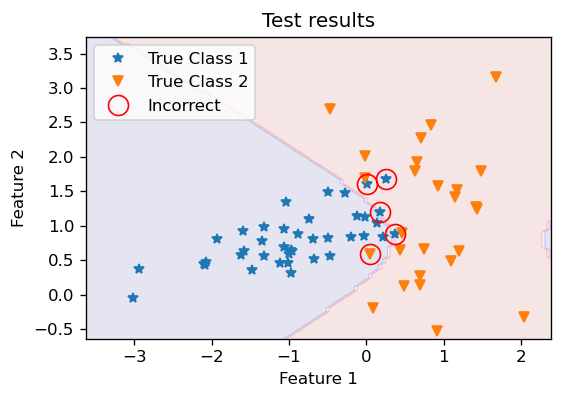

In [5]:
def make_meshgrid(X, ngrid=100, slack=0.2):
    if len(X.shape) > 2:
        warnings.warn('Grid visualization only work for 2D or less!')
    xmin, xmax = X[:, 0].min(),  X[:, 0].max()
    ymin, ymax = X[:, 1].min(),  X[:, 1].max()
    
    # Apply some slack so points are are not near the edge
    xmin *= 1 - np.sign(xmin) * slack
    xmax *= 1 + np.sign(xmax) * slack
    ymin *= 1 - np.sign(ymin) * slack
    ymax *= 1 + np.sign(ymax) * slack
    
    dx = (xmax - xmin) / ngrid
    dy = (ymax - ymin) / ngrid
    x = np.arange(xmin, xmax, dx)
    y = np.arange(ymin, ymax, dy)
    xx, yy = np.meshgrid(x, y)
    return (xx, yy)


def plot_decision(xx, yy, clf, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = pl.contourf(xx, yy, Z, **params)
    return out


for c in range(n_classes):
    pl.plot(X_test[y_test==c, 0], X_test[y_test==c, 1], linestyle='', marker=next(marker))

pl.plot(X_test[y_predicted_test != y_test, 0], X_test[y_predicted_test != y_test, 1], 'or',
        markersize=12, markerfacecolor='none')
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')
pl.legend(('True Class 1', 'True Class 2', 'Incorrect'), loc='best')
pl.title('Test results')

# Plot decision function
xx, yy = make_meshgrid(X_test)
plot_decision(xx, yy, model, cmap='seismic', alpha=0.1)

## Clustering using mixture modeling

### Create and visualize a 2D dataset

Text(0, 0.5, 'Feature 2')

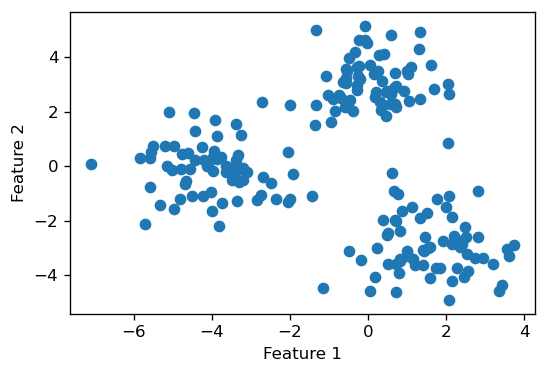

In [6]:
n_clusters = 3
centers = np.asarray([[-4, 0], [0, 3], [1.5, -3]])
X, y = datasets.make_blobs(centers=centers, n_features=n_features,
                           n_samples=n_samples)

pl.plot(X[:, 0], X[:, 1], 'o')
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')

### Use a Gaussian mixture model

The number of clusters is a hyperparameter

Log-likelihood = -3.882424703774175, AIC = 1586.96988150967


Text(0, 0.5, 'Feature 2')

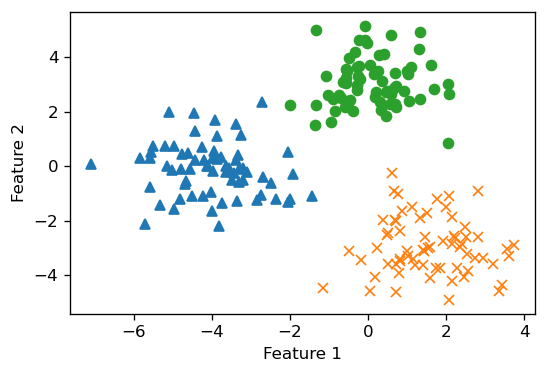

In [7]:
from sklearn import mixture
ncomps = 3
model = mixture.GaussianMixture(n_components=ncomps)
y = model.fit_predict(X)
print(f'Log-likelihood = {model.score(X)}, AIC = {model.aic(X)}')
for k in range(ncomps):
    pl.plot(X[y==k, 0], X[y==k, 1], marker=next(marker), linestyle='')
pl.xlabel('Feature 1')
pl.ylabel('Feature 2')

## Apply naive Bayes classifier to Wisconsin breast cancer dataset after PCA for dimensionality reduction

Dataset is included with ```sklearn``` but comes from:
W.H. Wolberg, W.N. Street, D.M. Heisey, and O.L. Mangasarian. Computer-derived nuclear features distinguish malignant from benign breast cytology. Human Pathology, 26:792--796, 1995.

Here, fine-needle aspirates (FNA; a type of biopsy) of breast mass are obtained, imaged, and the digitized images are processed to extract features pertaining to the characteristics of the cell nuclei present in the image. The goal is to classify each biopsy as **malignant** or **benign** based on the image.

Ten real-valued features are computed for each cell nucleus:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)

For each image, across nuceli, the mean, standard error,
and "worst" or largest (mean of the three largest values) of these features were computed. This yields **30 features per sample**.
For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.


In [8]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

dat = load_breast_cancer()
X = dat.data
y = dat.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

# Do PCA to get two dimensions
pc = PCA(n_components=2)
pc.fit(X_train)
X_train_pc = pc.transform(X_train)
X_test_pc = pc.transform(X_test)

In [9]:
model = GaussianNB()
model.fit(X_train_pc, y_train)
y_predicted_train = model.predict(X_train_pc)
y_predicted_test = model.predict(X_test_pc)

acc_train = (y_predicted_train == y_train).sum() * 100. / y_train.shape[0]
acc_test = (y_predicted_test == y_test).sum() * 100. / y_test.shape[0]

print(f'Training accuracy = {acc_train:0.1f}%, Test accuracy = {acc_test:0.1f}%')

Training accuracy = 91.3%, Test accuracy = 87.4%


### Visualize results

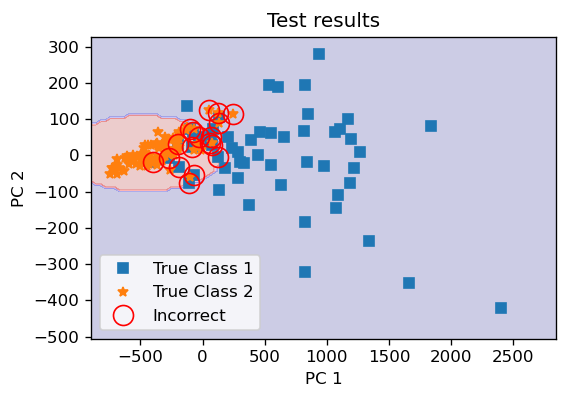

In [10]:
n_classes = 2
for c in range(n_classes):
    pl.plot(X_test_pc[y_test==c, 0], X_test_pc[y_test==c, 1], linestyle='', marker=next(marker))

pl.plot(X_test_pc[y_predicted_test != y_test, 0], X_test_pc[y_predicted_test != y_test, 1], 'or',
        markersize=12, markerfacecolor='none')
pl.xlabel('PC 1')
pl.ylabel('PC 2')
pl.legend(('True Class 1', 'True Class 2', 'Incorrect'), loc='best')
pl.title('Test results')

# Plot decision function
xx, yy = make_meshgrid(X_test_pc)
plot_decision(xx, yy, model, cmap='seismic', alpha=0.2)

## Apply naive Bayes classifier to high-dimensional Wisconsin breast cancer dataset (no PCA)

In [11]:
model = GaussianNB()
# Using X_train and X_test instead of X_train_pc and X_test_pc
model.fit(X_train, y_train)
y_predicted_train = model.predict(X_train)
y_predicted_test = model.predict(X_test)

acc_train = (y_predicted_train == y_train).sum() * 100. / y_train.shape[0]
acc_test = (y_predicted_test == y_test).sum() * 100. / y_test.shape[0]

print(f'Training accuracy = {acc_train:0.1f}%, Test accuracy = {acc_test:0.1f}%')

Training accuracy = 94.4%, Test accuracy = 93.7%


### Conclusion about breast cancer dataset

A simple naive Bayes classifier is able to obtain 90+% accuracy in biopsy classification.